In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras

from keras.layers import Convolution2D, Flatten, Dense, MaxPool2D, Activation, Dropout
from keras.layers import UpSampling2D, Reshape, ZeroPadding2D, Input
from keras.models import Model
from keras.utils import np_utils

In [2]:
# Data loading

ds = pd.read_csv('../data/train.csv')
ds.shape
data = ds.values[:10000]

In [4]:
X = data[:, 1:]/255.0
y = np_utils.to_categorical(data[:, 0])

print X.shape, y.shape

(10000, 784) (10000, 10)


In [5]:
split = int(0.8 * X.shape[0])

X_train = X[:split].reshape((-1, 28, 28, 1))
X_test = X[split:].reshape((-1, 28, 28, 1))
print X_train.shape, X_test.shape

(8000, 28, 28, 1) (2000, 28, 28, 1)


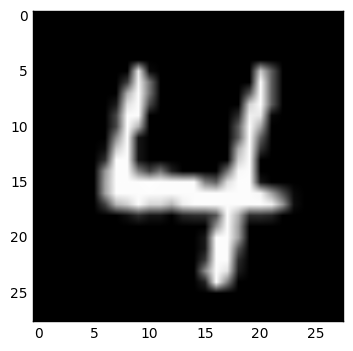

In [8]:
n_img = 42

plt.imshow(X_train[n_img].reshape((28, 28)), cmap='gray')
plt.show()

In [72]:
inp = Input(shape=(28, 28, 1))

c1 = Convolution2D(32, (5, 5))
a1 = Activation('relu')

m1 = MaxPool2D(pool_size=(2, 2))

c2 = Convolution2D(8, (3, 3))
a2 = Activation('relu')

m2 = MaxPool2D(pool_size=(2, 2))
f1 = Flatten()

emb_shape = 32
e1 = Dense(emb_shape)
emb = Activation('tanh')

fc1 = Dense(200)
a3 = Activation('sigmoid')

re1 = Reshape((5, 5, 8))

up1 = UpSampling2D(size=(2, 2))

zp1 = ZeroPadding2D(padding=(1, 1))
dc1 = Convolution2D(32, (3, 3), padding='same', activation='relu')

up2 = UpSampling2D(size=(2, 2))

zp2 = ZeroPadding2D(padding=(2, 2))
dc2 = Convolution2D(1, (5, 5), padding='same', activation='relu')


out_enc = emb(e1(f1(m2(a2(c2(m1(a1(c1(inp)))))))))
out_model = dc2(zp2(up2(dc1(zp1(up1(re1(a3(fc1(out_enc)))))))))


model = Model(inputs=[inp], outputs=[out_model])
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

encoder = Model(inputs=[inp], outputs=[out_enc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_66 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 10, 10, 8)         2312      
_________________________________________________________________
activation_67 (Activation)   (None, 10, 10, 8)         0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 5, 5, 8)           0         
__________

In [73]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_66 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 10, 10, 8)         2312      
_________________________________________________________________
activation_67 (Activation)   (None, 10, 10, 8)         0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 5, 5, 8)           0         
__________

In [74]:
dec_inp = Input(shape=(emb_shape,))

dec_out = dc2(zp2(up2(dc1(zp1(up1(re1(a3(fc1(dec_inp)))))))))

decoder = Model(inputs=[dec_inp], outputs=[dec_out])
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               6600      
_________________________________________________________________
activation_69 (Activation)   (None, 200)               0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 5, 5, 8)           0         
_________________________________________________________________
up_sampling2d_27 (UpSampling (None, 10, 10, 8)         0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 12, 12, 32)        2336      
__________

In [75]:
model.fit(X_train, X_train,
         epochs=10,
         shuffle=True,
        batch_size=100,
         validation_data=(X_test, X_test))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 2s - loss: 0.0641 - acc: 0.8015 - val_loss: 0.0501 - val_acc: 0.7992

In [76]:
enc_out = encoder.predict(X_train[:100])
print enc_out.shape

(100, 32)


In [80]:
rnd_vec = np.random.uniform(low=-1, high=1, size=(20, emb_shape))
print rnd_vec.shape

(20, 32)


In [81]:
rec = decoder.predict(rnd_vec)
print rec.shape

(20, 28, 28, 1)


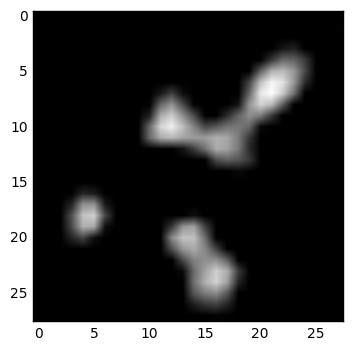

In [83]:
nx = 12

plt.figure(0)
#plt.imshow(X_train[nx].reshape((28, 28)), cmap='gray')

#plt.figure(1)
plt.imshow(rec[nx].reshape((28, 28)), cmap='gray')

plt.show()